<a href="https://colab.research.google.com/github/theskyvalker/matchboxdao-mlcourse/blob/main/Regression_HW_Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!unzip "archive (1).zip"

Archive:  archive (1).zip
replace rent_all.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: rent_all.csv            


# Singapore Condo Rental Dataset

First, import all needed libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(style="white")
from datetime import datetime

# Exploratory Data Analysis

In [3]:
data = pd.read_csv('rent_all.csv')
data.head()

,id,building,street,district,room,rent,rentk,area,lower,year,month
0,1,SKYLINE RESIDENCES,TELOK BLANGAH ROAD,4,3,7300,7.3,1300 to 1400,1300,22,12
1,2,REFLECTIONS AT KEPPEL BAY,KEPPEL BAY VIEW,4,3,5800,5.8,1500 to 1600,1500,22,12
2,3,ONE SHENTON,SHENTON WAY,1,2,7300,7.3,1100 to 1200,1100,22,12
3,4,THE ROCHESTER RESIDENCES,ROCHESTER DRIVE,5,2,6500,6.5,1300 to 1400,1300,22,12
4,5,THE RESIDENCES AT W SINGAPORE SENTOSA COVE,OCEAN WAY,4,2,7000,7.0,1200 to 1300,1200,22,12


In [4]:
# We can get a quick overview of all the numeric columns of our data with this

data.describe()

,id,district,room,rent,rentk,lower,year,month
count,432191.000000,432191.000000,432191.000000,432191.000000,432191.000000,432191.000000,432191.000000,432191.000000
mean,216096.000000,13.005363,6.376861,3764.759535,3.764760,1030.388648,20.029779,6.576759
std,124762.939433,6.470458,13.410442,2324.058875,2.324059,539.619998,1.393993,3.374170
min,1.000000,1.000000,0.000000,307.000000,0.307000,100.000000,18.000000,1.000000
25%,108048.500000,9.000000,2.000000,2450.000000,2.450000,600.000000,19.000000,4.000000
50%,216096.000000,13.000000,2.000000,3100.000000,3.100000,900.000000,20.000000,7.000000
75%,324143.500000,18.000000,3.000000,4250.000000,4.250000,1300.000000,21.000000,9.000000
max,432191.000000,28.000000,50.000000,170000.000000,170.000000,3000.000000,22.000000,12.000000


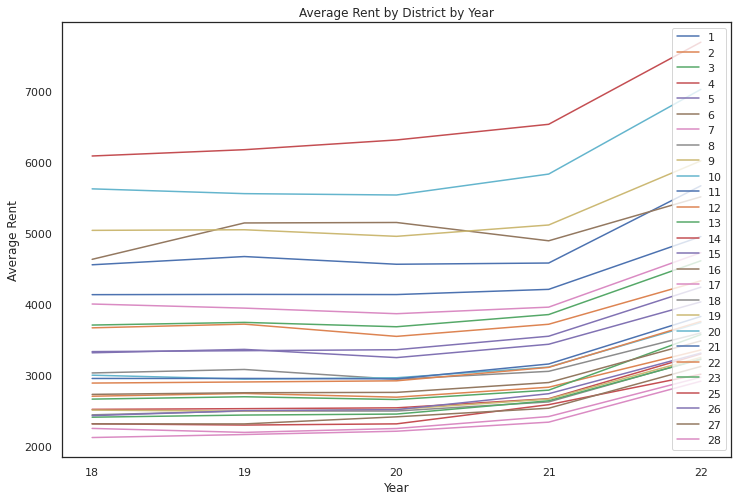

In [5]:
# group rent data by year and district to check the pattern year on year
# we expect this to be an ascending pattern overall

grouped_data = data.groupby(['year', 'district']).mean()['rent'].unstack()

# plot the data
grouped_data.plot(kind='line', figsize=(12, 8))
plt.xlabel('Year')
plt.ylabel('Average Rent')
plt.title('Average Rent by District by Year')
plt.legend(loc='best')
plt.xticks(range(18, 23))

plt.show()

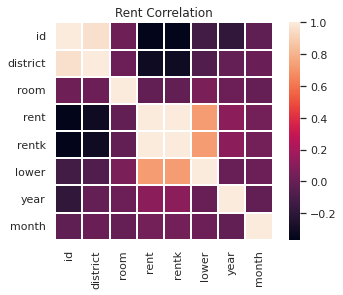

In [6]:
# Compute the correlation matrix using the current features
corr = data.corr()

# Draw the correlation matrix
sns.heatmap(corr, square=True, linewidths=.4)

plt.title("Rent Correlation")
plt.show()

# Model Version 1: Baseline

The easiest model to do would be to take just the numeric features from the dataset which includes the disctrict as a measure of the locality data

In [7]:
# check how many have room=50 (This represents missing or N/A room data)

print("No. of data points with N/A room data {}".format(
    len(data[data['room'] == 50])))

# what is the % of these data points from our total data

print("% of datapoints with N/A room data {}".format(
    len(data[data['room'] == 50])/len(data) * 100))

No. of data points with N/A room data 37171
% of datapoints with N/A room data 8.600595570014184


In [8]:
# We can remove these data points for now since this is less than 10% of our
# data

data = data.drop(data[data['room'] == 50].index)
print("Data points left after removing room=N/A data: {}".format(len(data)))

Data points left after removing room=N/A data: 395020


In [9]:
# separate the data into train and test sets - we use years 2018-2021 as train
# and try to predict the rentals for 2022
train_data = data.loc[data['year'] != 22]
test_data = data.loc[data['year'] == 22]

# print the total number of data points in the train and test sets
print(f"Number of data points in train set: {len(train_data)}")
print(f"Number of data points in test set: {len(test_data)}")

Number of data points in train set: 318522
Number of data points in test set: 76498


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# extract the features and target variables
X_train = train_data[['year', 'district', 'room', 'lower']]
y_train = train_data['rent']
X_test = test_data[['year', 'district', 'room', 'lower']]
y_test = test_data['rent']

# create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# predict the target variable on the test data
y_pred = model.predict(X_test)

# evaluate the model on the test data and print the metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"R2-score: {r2:.3f}")

MAE: 1171.286
R2-score: 0.475


# Results of the Baseline Model

Our baseline model has an MAE of 1171 meaning that any prediction made by the model can be off by +- 1171 and we can try to do better

# Next Steps

Let's try to do some feature engineering to try and improve the result

In [11]:
# psf -> per square feet -> rent normalized by the area of the place
data['psf'] = data['rent'] / data['lower']

# district_psf_cummean -> 
district_psf_cummean = data.groupby(['district', 'year'])['psf'].mean().groupby('district').cumsum().reset_index()
district_psf_cummean.rename(columns={'psf': 'district_mean_psf'}, inplace=True)
data = data.merge(district_psf_cummean, on=['district', 'year'])

In [12]:
data.describe()

,id,district,room,rent,rentk,lower,year,month,psf,district_mean_psf
count,395020.000000,395020.000000,395020.000000,395020.000000,395020.000000,395020.000000,395020.000000,395020.000000,395020.000000,395020.000000
mean,215617.820252,12.990342,2.271966,3804.981373,3.804981,1027.826692,20.025247,6.581525,3.965569,11.585343
std,125278.213608,6.489465,0.918521,2324.811249,2.324811,532.637635,1.391645,3.376423,1.437632,6.121037
min,1.000000,1.000000,0.000000,307.000000,0.307000,100.000000,18.000000,1.000000,0.500000,2.335456
25%,106870.750000,9.000000,2.000000,2500.000000,2.500000,600.000000,19.000000,4.000000,2.900000,6.602611
50%,213415.500000,13.000000,2.000000,3150.000000,3.150000,900.000000,20.000000,7.000000,3.714286,11.023135
75%,325556.250000,18.000000,3.000000,4300.000000,4.300000,1200.000000,21.000000,9.000000,4.750000,15.868243
max,432191.000000,28.000000,8.000000,170000.000000,170.000000,3000.000000,22.000000,12.000000,56.666667,42.574763


In [13]:
# we do a new split with the new data
train_data = data.loc[data['year'] != 22]
test_data = data.loc[data['year'] == 22]

# extract the features and target variables
X_train = train_data[['year', 'district_mean_psf', 'room', 'lower']]
y_train = train_data['rent']
X_test = test_data[['year', 'district_mean_psf', 'room', 'lower']]
y_test = test_data['rent']

# create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# predict the target variable on the test data
y_pred = model.predict(X_test)

# evaluate the model on the test data and print the metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"R2-score: {r2:.3f}")

MAE: 1137.176
R2-score: 0.519


We see that we have some improvement. However, we can try to also encode the building and street information in a similar way by taking the per-square-foot pricing at a building and street level into consideration as well in addition to the psf by district

In [14]:
building_psf_cummean = data.groupby(['building', 'year'])['psf'].mean().groupby('building').cumsum().reset_index()
building_psf_cummean.rename(columns={'psf': 'building_mean_psf'}, inplace=True)
data = data.merge(building_psf_cummean, on=['building', 'year'])

street_psf_cummean = data.groupby(['street', 'year'])['psf'].mean().groupby('street').cumsum().reset_index()
street_psf_cummean.rename(columns={'psf': 'street_mean_psf'}, inplace=True)
data = data.merge(street_psf_cummean, on=['street', 'year'])

In [15]:
# we do a new split with the new data
train_data = data.loc[data['year'] != 22]
test_data = data.loc[data['year'] == 22]

# extract the features and target variables
X_train = train_data[['year', 'district_mean_psf', 'street_mean_psf', 'building_mean_psf', 'room', 'lower']]
y_train = train_data['rent']
X_test = test_data[['year', 'district_mean_psf', 'street_mean_psf', 'building_mean_psf', 'room', 'lower']]
y_test = test_data['rent']

# create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# predict the target variable on the test data
y_pred = model.predict(X_test)

# evaluate the model on the test data and print the metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"R2-score: {r2:.3f}")

MAE: 1155.579
R2-score: 0.563


We see that we lose MAE but the R2-score improves. We can try other regression techniques and see if a non-linear method can improve the model further as opposed to linear regression.

In [16]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn import neighbors, tree
from sklearn.ensemble import RandomForestRegressor

# initialize different regression models
models = {
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'ElasticNet Regression': ElasticNet(),
    'KNN': neighbors.KNeighborsRegressor(10),
    'Decision Tree': tree.DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MAE = {mae:.2f}, R2 Score = {r2:.2f}")

Lasso Regression: MAE = 1153.67, R2 Score = 0.56
Ridge Regression: MAE = 1155.58, R2 Score = 0.56
ElasticNet Regression: MAE = 991.27, R2 Score = 0.61
KNN: MAE = 860.66, R2 Score = 0.75
Decision Tree: MAE = 1022.85, R2 Score = 0.52
Random Forest: MAE = 839.41, R2 Score = 0.74


We see that KNN and random forest techniques provide a better model, but there is still scope for improvement. External features may help improve this further but what we can do without that is to try polynomial features.

We should also apply a scaling technique on the features which we can do using the standard scaling method since it matters for a subset of our selected approaches even if it doesn't matter to the tree based approaches.

In [18]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# concatenate original and polynomial features
X_train_all = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train.columns))
X_test_all = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_test.columns))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all)

# assume 'X_test' is the test data
X_test_scaled = scaler.transform(X_test_all)

# train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MAE = {mae:.2f}, R2 Score = {r2:.2f}")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.121e+10, tolerance: 1.473e+08
  model = cd_fast.enet_coordinate_descent(


Lasso Regression: MAE = 1128.53, R2 Score = 0.66
Ridge Regression: MAE = 1035.58, R2 Score = 0.69
ElasticNet Regression: MAE = 850.49, R2 Score = 0.72
KNN: MAE = 913.82, R2 Score = 0.72
Decision Tree: MAE = 1006.39, R2 Score = 0.45
Random Forest: MAE = 821.04, R2 Score = 0.73


We see that KNN without polynomial features remains our best model so far and perhaps we don't have enough data to be able to make use of the additionally generated features. Let's take a look at how our predicted rental prices differ from the actual rental prices.

In [21]:
KNN_model = neighbors.KNeighborsRegressor(10)
KNN_model.fit(X_train, y_train)
y_pred = KNN_model.predict(X_test)

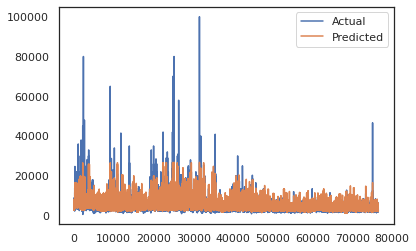

In [22]:
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()